In [4]:
!pip install pandas nltk scikit-learn openai python-dotenv networkx matplotlib

In [5]:
import os
import openai
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json
import pandas as pd
import numpy as np

In [6]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

In [7]:
def chat(system_prompt, user_prompt = '', model = 'gpt-4o', temperature = 0, **kwargs):
    ''' This replies the user based on a system prompt and user prompt to call OpenAI Chat Completions API '''
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        temperature = temperature,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        **kwargs
    )
    res = response.choices[0].message.content
    return res

In [51]:
def build_knowledge_graph(transcript_summary):
    '''Extract knowledge graph from summarized text using schema'''
    completion = openai.chat.completions.create(
        model="gpt-4o",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": '''You are a knowledge graph builder, extract nodes and edges for a knowledge graph from the following text.
            You are to output relations between two objects in the form (object_1, relation, object_2). 
            All information about dates must be included.
            Example Input: John bought a laptop
            Example Output: [('John', 'bought', 'laptop')]
            Example Input: John built a house in 2019
            Example Output: [('John', 'built', 'house'), ('house', 'built in', '2019')]
            The final output should be in JSON as follows, make sure the key is exactly: {"List of triplets": "List of triplets of the form (object_1, relation, object_2), type: list"}'''},
            {"role": "user", "content": f"Here's the text: {transcript_summary}"}
        ]
    )

    answer = json.loads(completion.choices[0].message.content) if completion.choices else "No response"

    return answer

In [52]:
def plot_graph(kg):
    ''' Plots graph based on knowledge graph '''
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in kg['List of triplets'])

    # Plot the graph
    plt.figure(figsize=(10,6), dpi=300)
    pos = nx.spring_layout(G, k=3, seed=0)

    nx.draw_networkx_nodes(G, pos, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Display the plot
    plt.axis('off')
    plt.show()

In [53]:
# Function to merge new triplets into the existing knowledge graph
def merge_knowledge_graphs(existing_kg, new_kg):
    existing_triplets = set(tuple(triplet) for triplet in existing_kg['List of triplets'])
    new_triplets = set(tuple(triplet) for triplet in new_kg['List of triplets'])
    merged_triplets = existing_triplets.union(new_triplets)
    return {'List of triplets': list(merged_triplets)}

In [66]:
# Initialize an empty knowledge graph or load from a saved state
existing_kg = {'List of triplets': []}

In [67]:
# Example of new input to be added to the knowledge graph
new_input = "Before GPT-4o, users could interact with ChatGPT using Voice Mode, which operated with three separate models. GPT-4o will integrate these capabilities into a single model that's trained across text, vision, and audio. This unified approach ensures that all inputs—whether text, visual, or auditory—are processed cohesively by the same neural network."

In [76]:
# Build knowledge graph from new input
new_kg = build_knowledge_graph(new_input)
print(new_kg)

{'List of triplets': [['users', 'could interact using', 'Voice Mode'], ['Voice Mode', 'operated with', 'three separate models'], ['GPT-4o', 'will integrate', "three separate models' capabilities"], ['GPT-4o', 'will be trained across', 'text'], ['GPT-4o', 'will be trained across', 'vision'], ['GPT-4o', 'will be trained across', 'audio'], ['unified approach', 'ensures', 'all inputs are processed cohesively']]}


In [77]:
# Merge the new knowledge graph into the existing one
merged_kg = merge_knowledge_graphs(existing_kg, new_kg)

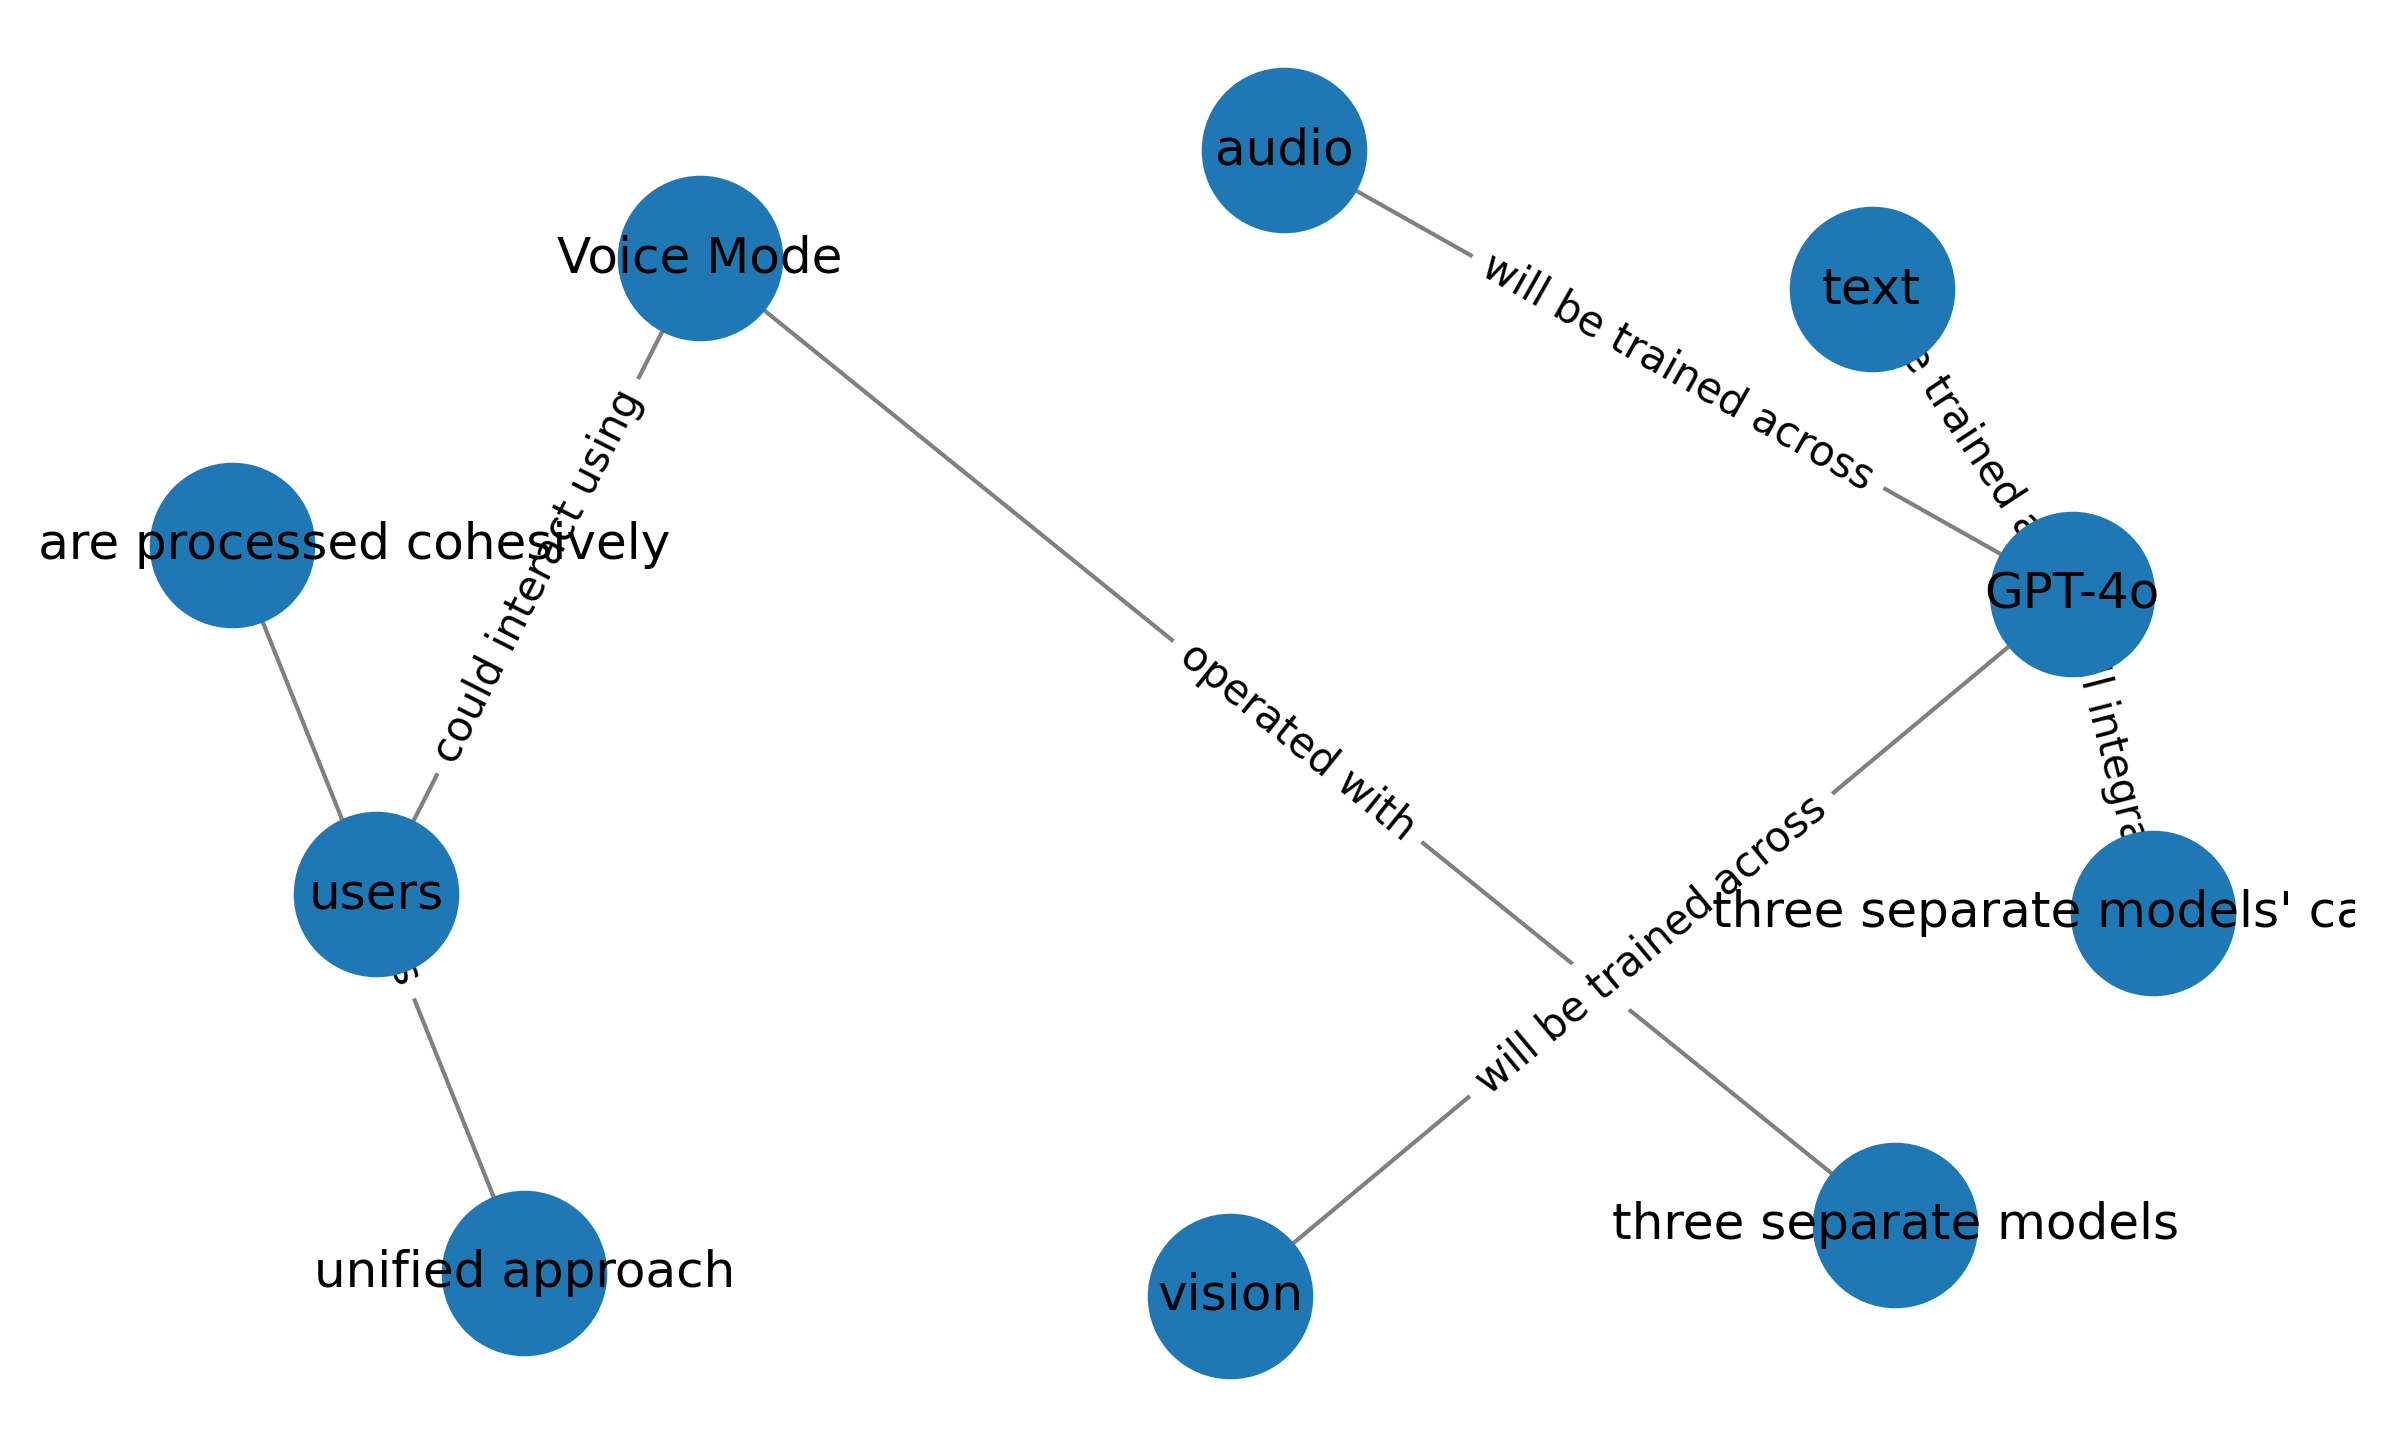

In [78]:
# Plot the updated knowledge graph
plot_graph(merged_kg)

In [79]:
import datetime
# Get the current datetime
current_datetime = datetime.datetime.now()

# Format the datetime as a string
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Create the title with the datetime
title_with_datetime = f"updated_knowledge_graph_{formatted_datetime}.json"

# Save the updated knowledge graph to a file
with open(f'saved_kg/{title_with_datetime}', 'w') as f:
    json.dump(merged_kg, f)


In [72]:
def parse_knowledge_graph(kg, question):
    '''Parse knowledge graph to extract relevant relations'''
    completion = openai.chat.completions.create(
        model="gpt-4o",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": f'''You are a knowledge graph parser for the following knowledge graph {kg}. 
            Only output the triplets that are relevant to the question.
            The final output should be in JSON as follows, make sure the key is exactly "List of triplets": {{"List of triplets": "List of triplets of the form (object1, relation, object2), type: list"}}'''},
            {"role": "user", "content": f"Here's the question: {question}"}
        ]
    )

    answer = json.loads(completion.choices[0].message.content) if completion.choices else "No response"

    return answer

In [80]:
# Parse knowledge graph to extract relevant relations
question = "What are the capabilities of GPT-4o?"
parsed_kg = parse_knowledge_graph(merged_kg, question)
print(parsed_kg)

{'List of triplets': [['GPT-4o', 'will be trained across', 'vision'], ['GPT-4o', 'will be trained across', 'audio'], ['GPT-4o', 'will be trained across', 'text'], ['GPT-4o', 'will integrate', "three separate models' capabilities"]]}


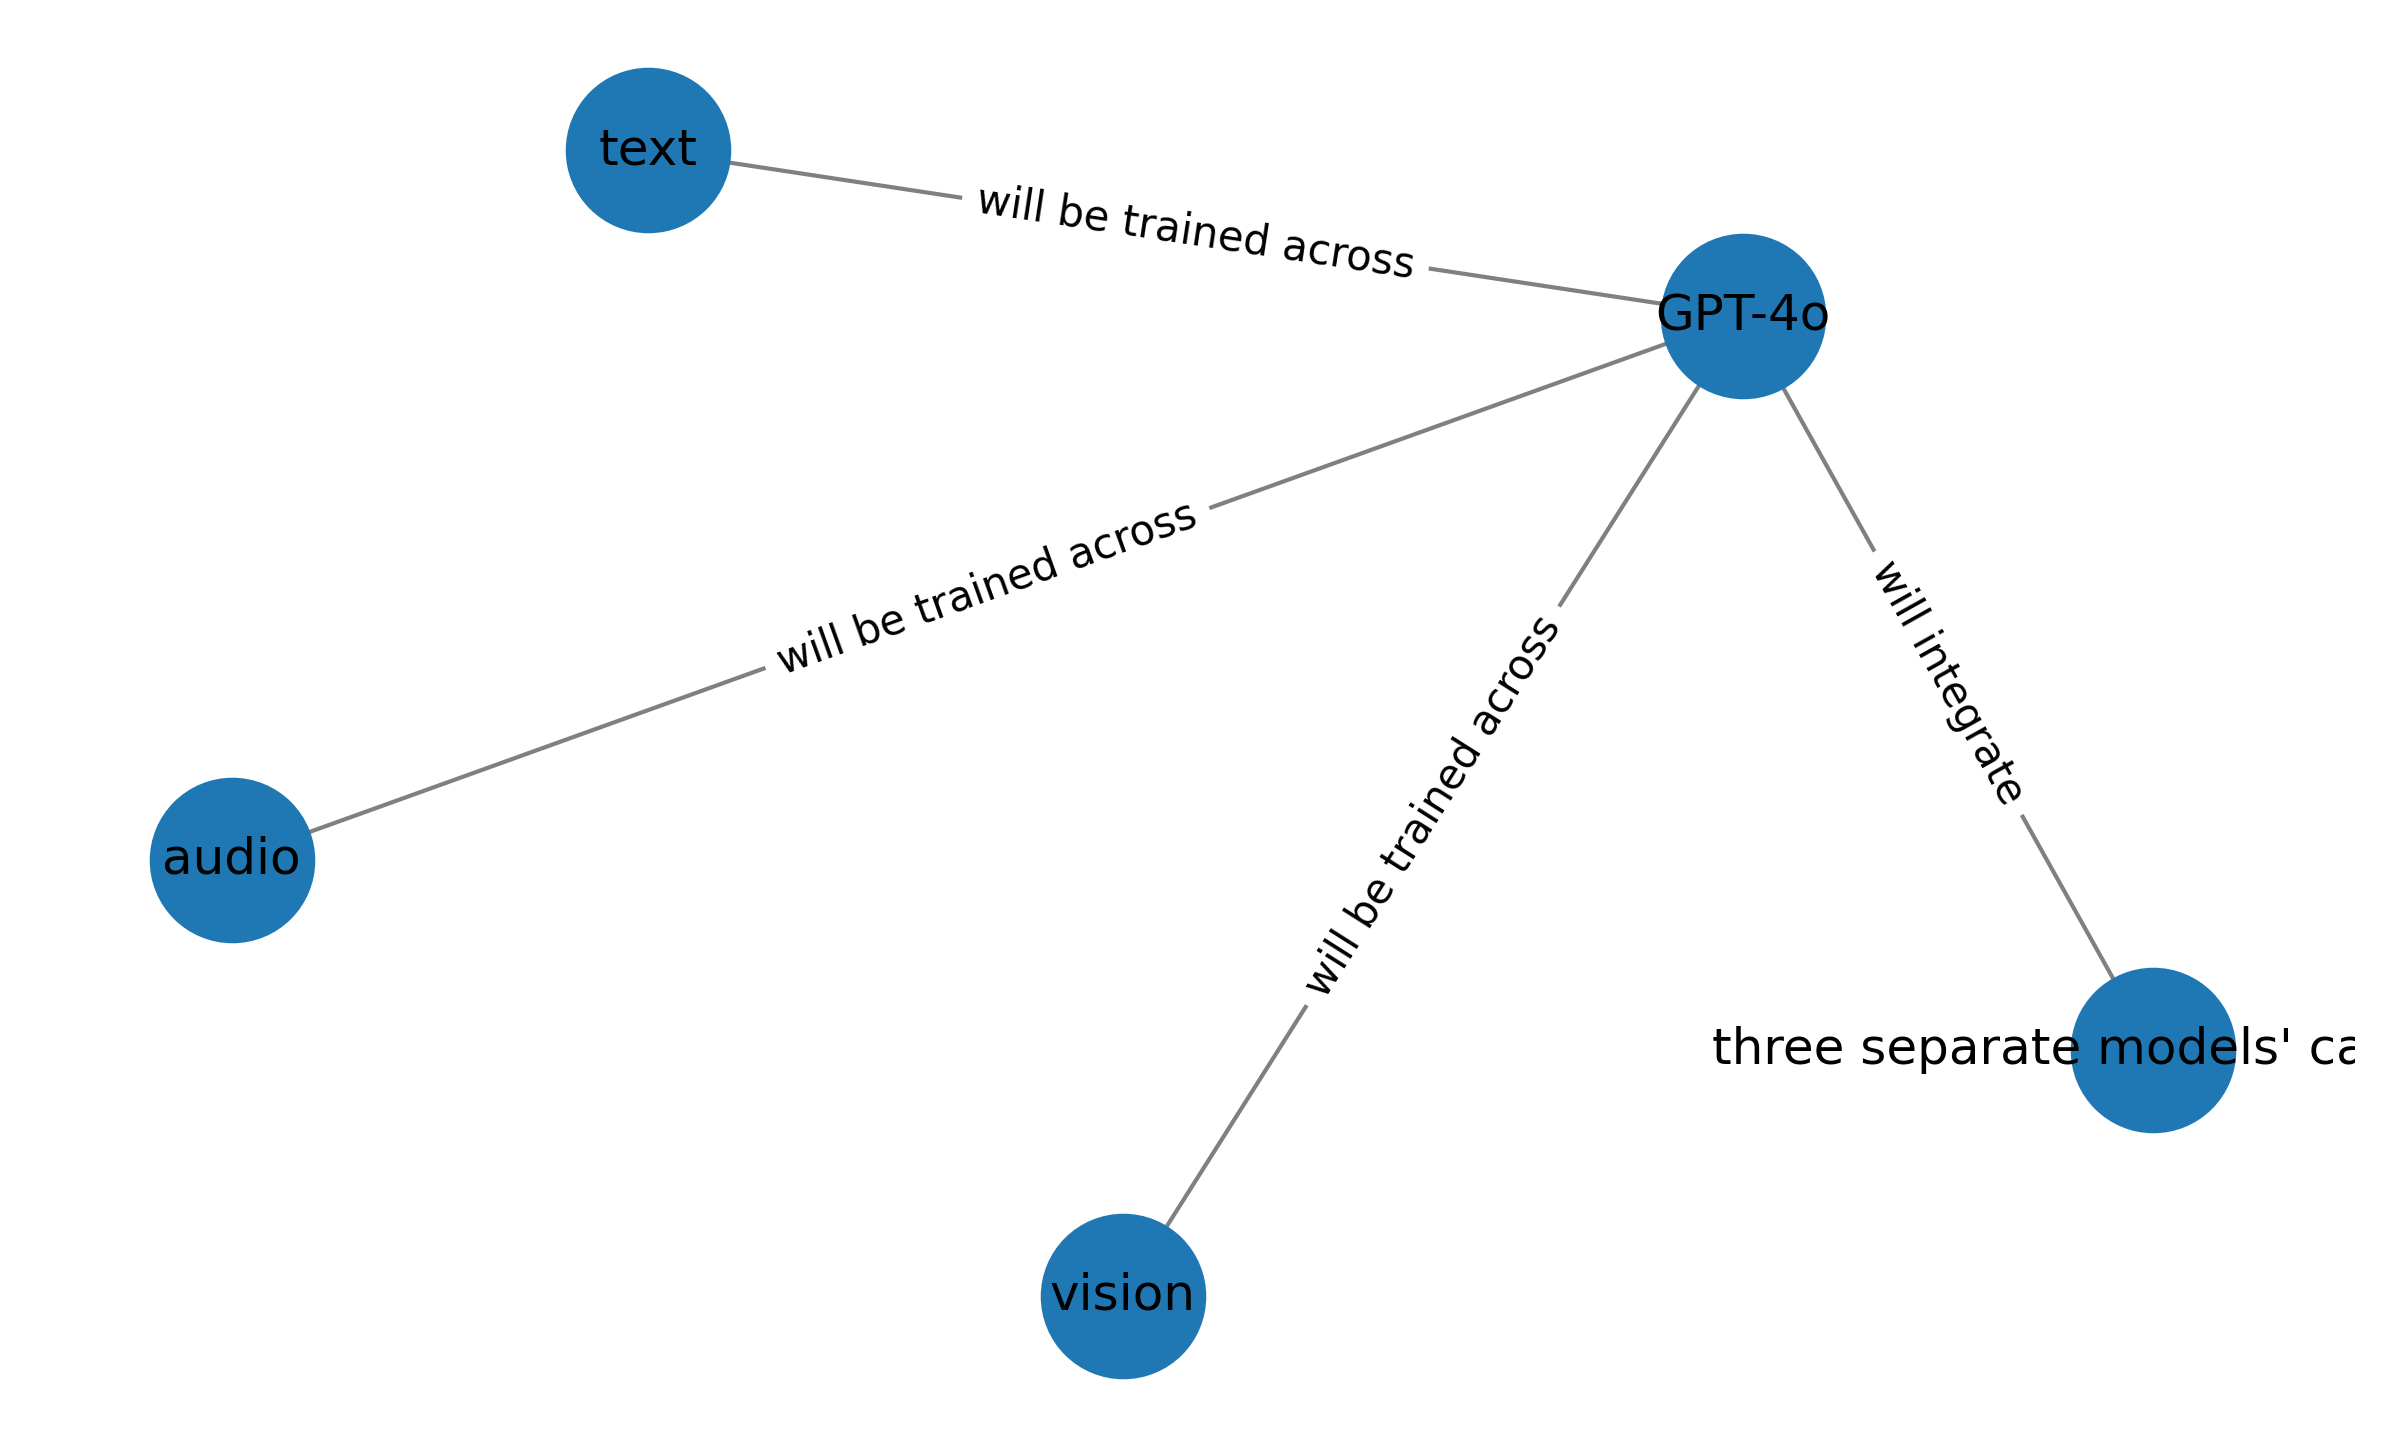

In [81]:
# Plot the parsed knowledge graph
plot_graph(parsed_kg)

In [82]:
# Generate a response to a question based on the parsed knowledge graph
response = chat(f'''Use the following knowledge graph to answer the following question. 
If you are unsure, output 'No Info'
Knowledge Graph: {parsed_kg['List of triplets']}''',
                    user_prompt = f'''Question: {question}''')

print('Response:', response)

Response: GPT-4o will be trained across vision, audio, and text, and it will integrate the capabilities of three separate models.


### Adding new data

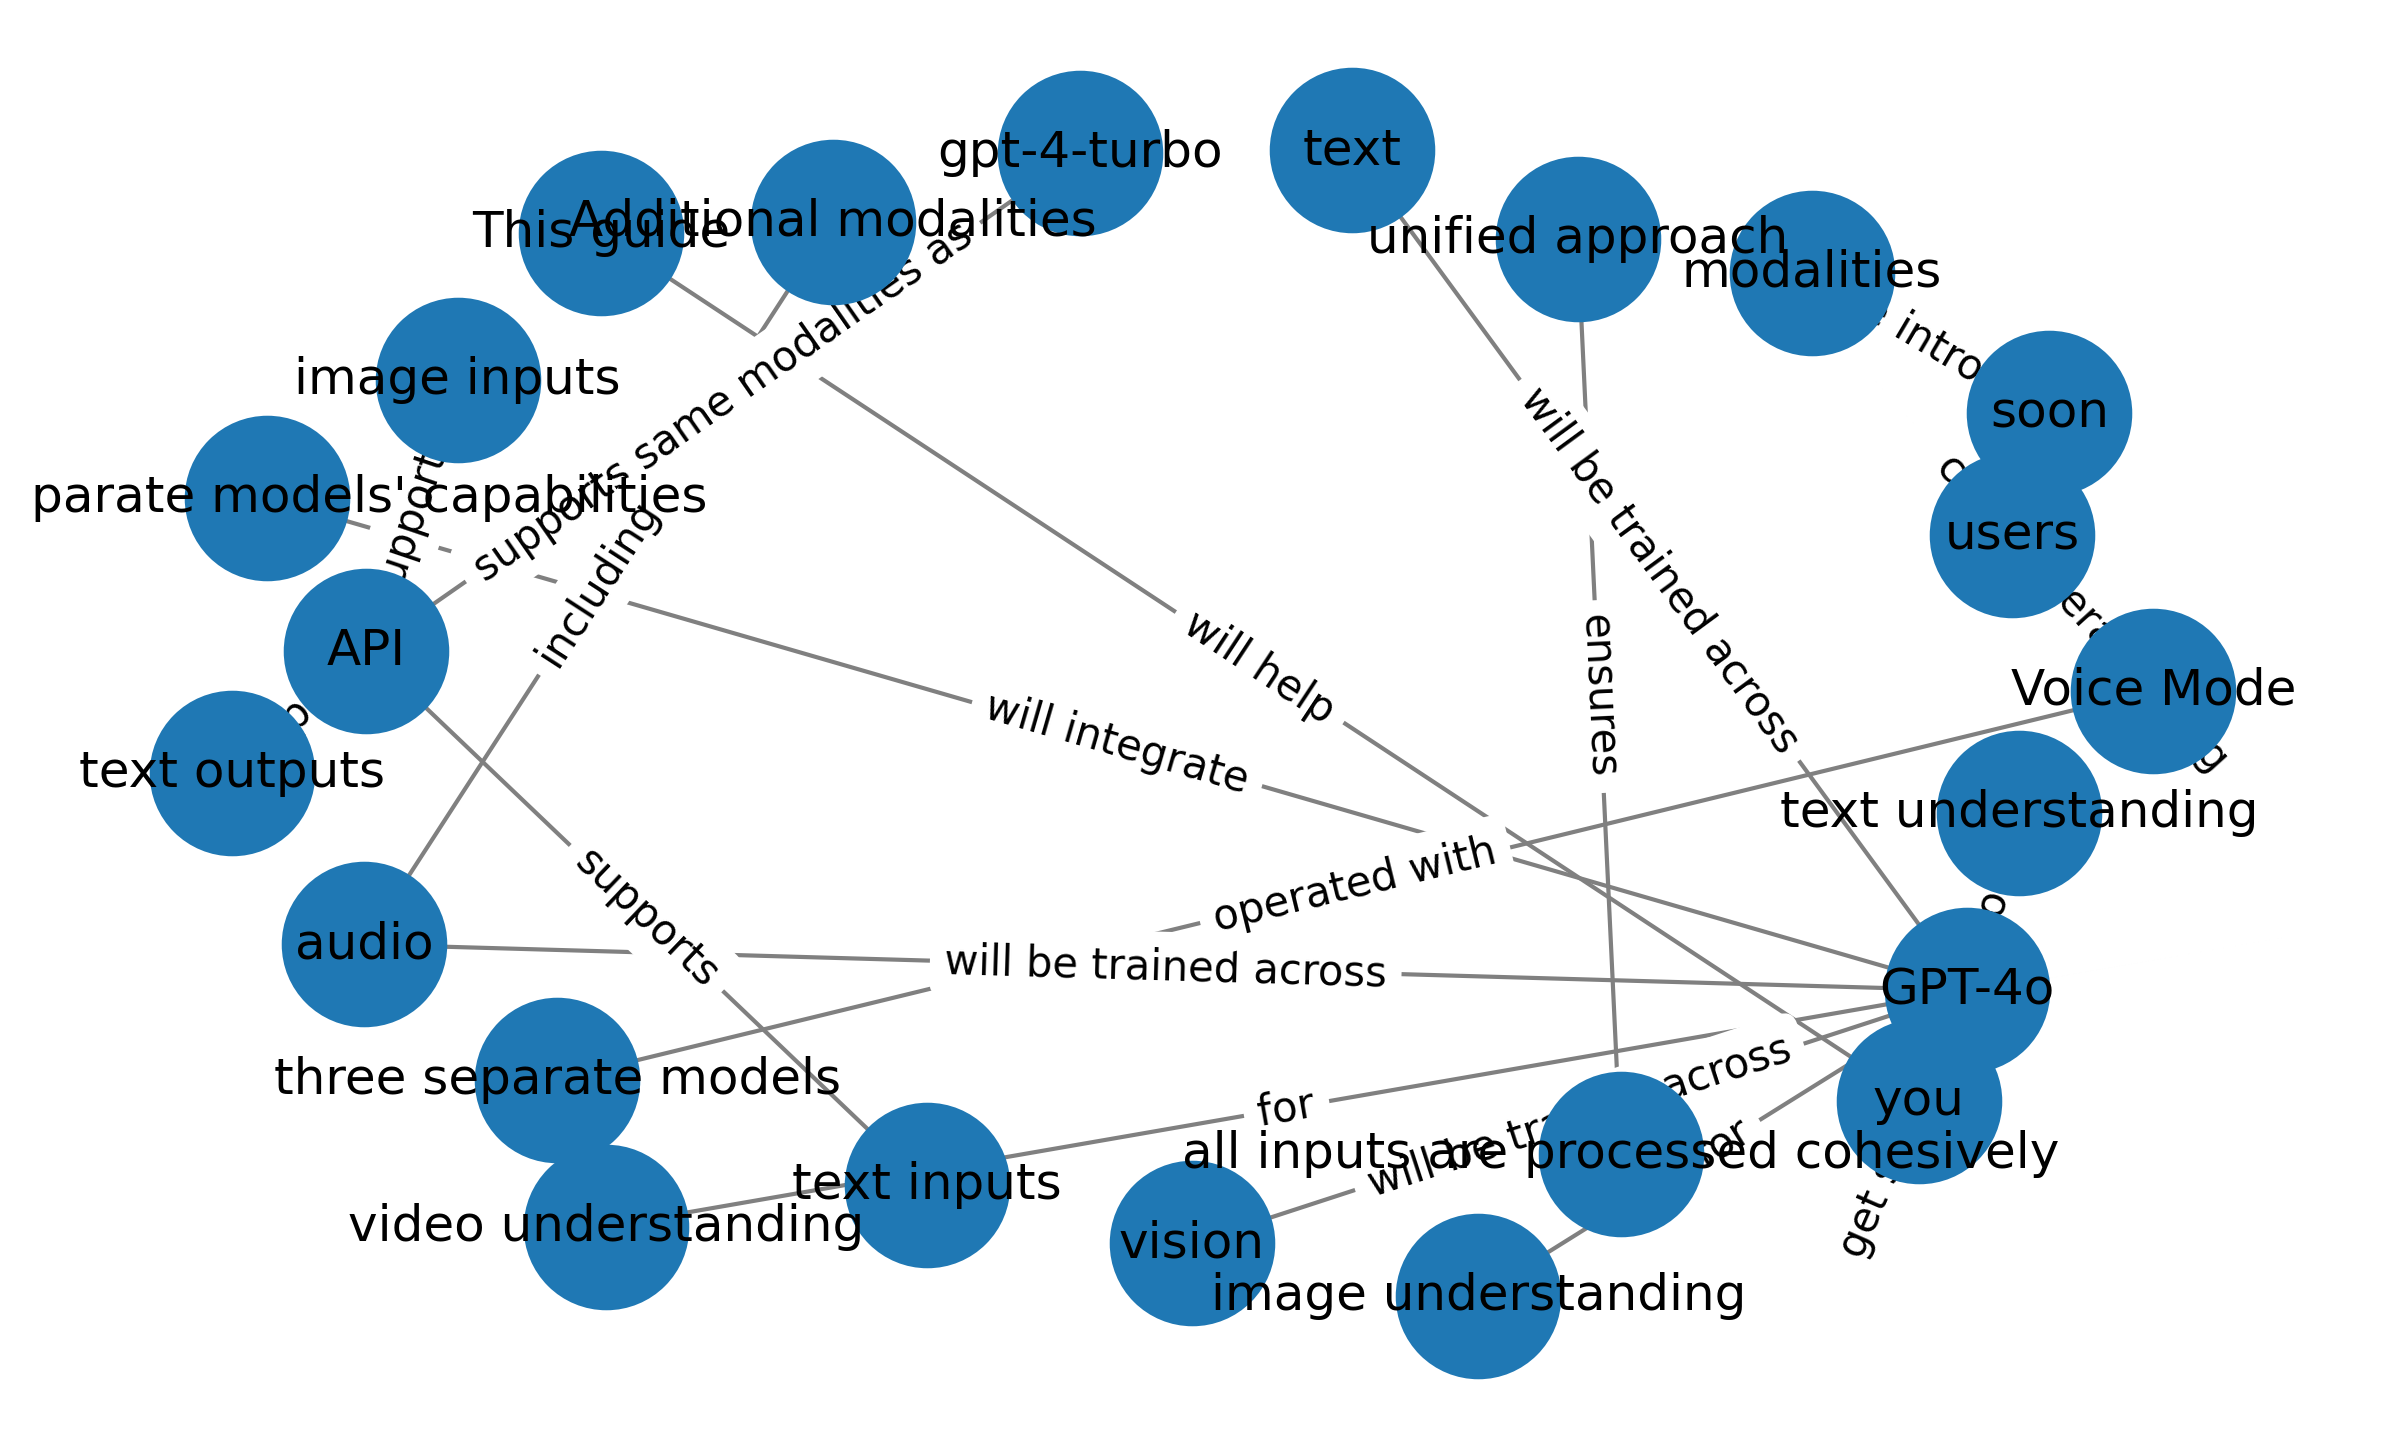

In [83]:
new_input = "Currently, the API supports {text, image} inputs only, with {text} outputs, the same modalities as gpt-4-turbo. Additional modalities, including audio, will be introduced soon. This guide will help you get started with using GPT-4o for text, image, and video understanding."
new_kg = build_knowledge_graph(new_input)
merged_kg = merge_knowledge_graphs(merged_kg, new_kg)
plot_graph(merged_kg)

In [84]:
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
title_with_datetime = f"updated_knowledge_graph_{formatted_datetime}.json"
with open(f'saved_kg/{title_with_datetime}', 'w') as f:
    json.dump(merged_kg, f)

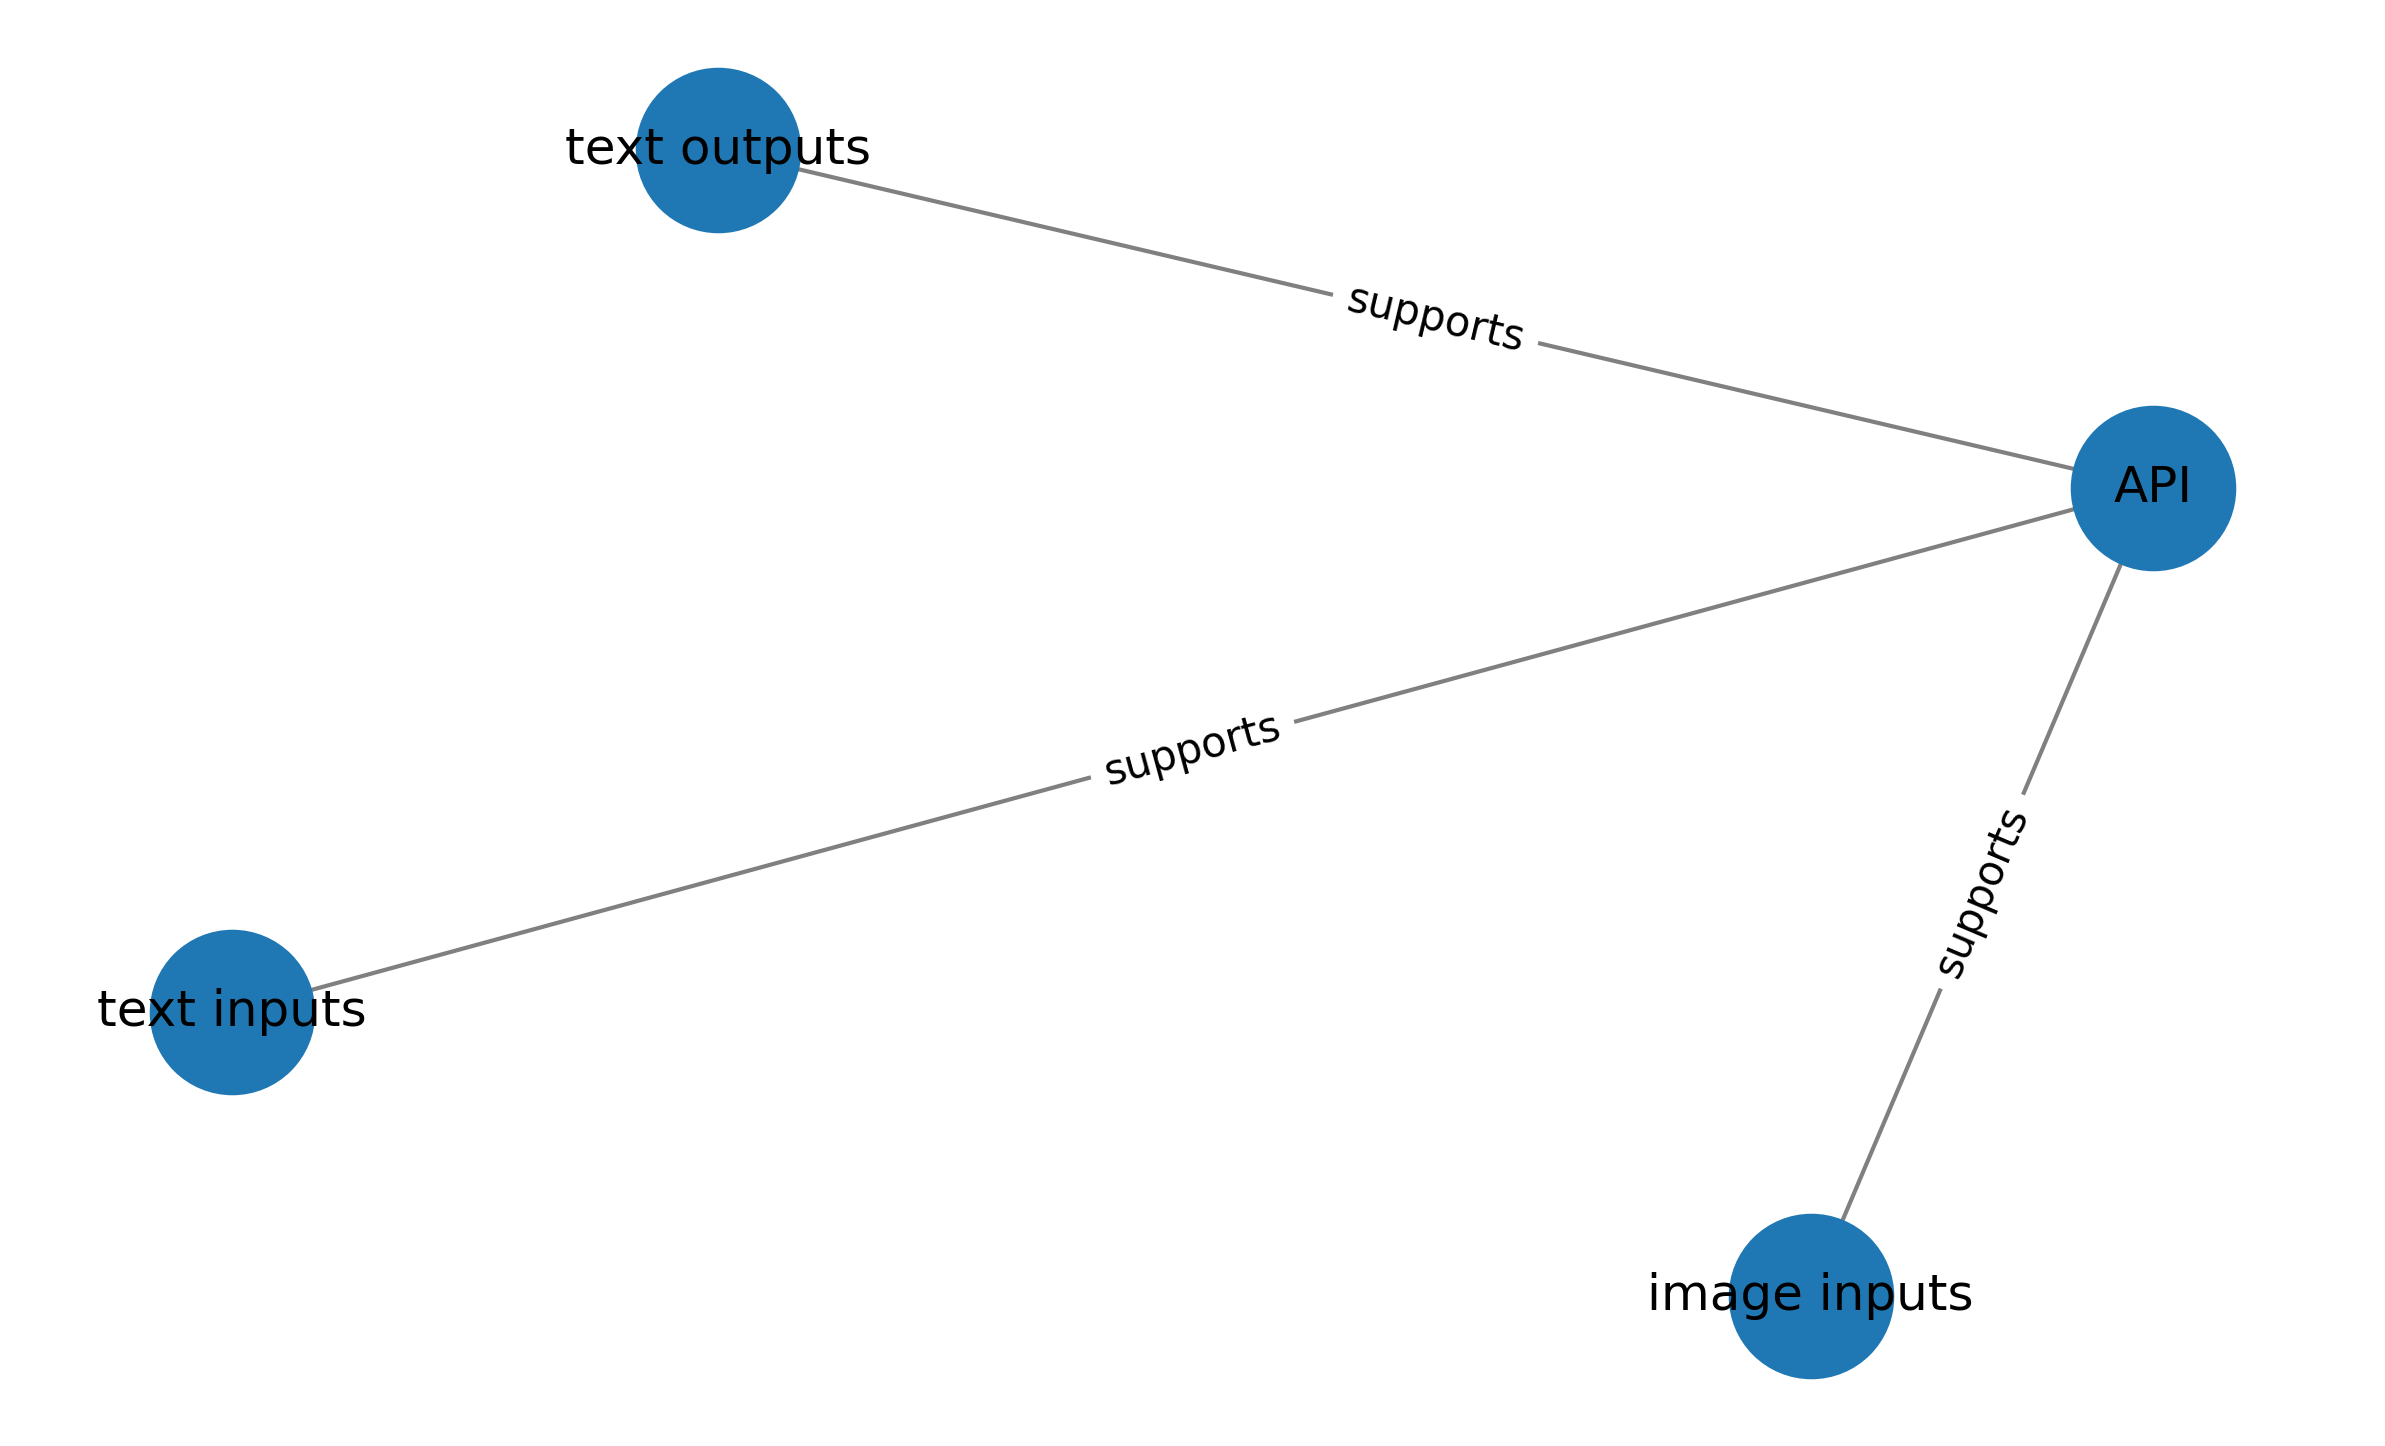

In [85]:
question = "What modalities does the API currently support?"
parsed_kg = parse_knowledge_graph(merged_kg, question)
plot_graph(parsed_kg)

In [86]:
response = chat(
    f'''Use the following knowledge graph to answer the following question. 
    If you are unsure, output 'No Info'
    Knowledge Graph: {parsed_kg['List of triplets']}''',
    user_prompt=f'''Question: {question}'''
)
print('Response:', response)

Response: The API currently supports image inputs, text inputs, and text outputs.


In [88]:
def plot_graph(kg):
    ''' Plots graph based on knowledge graph '''
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in kg['List of triplets'])

    # Plot the graph
    plt.figure(figsize=(10,6), dpi=300)
    pos = nx.spring_layout(G, k=3, seed=0)

    nx.draw_networkx_nodes(G, pos, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Display the plot
    plt.axis('off')
    plt.show()

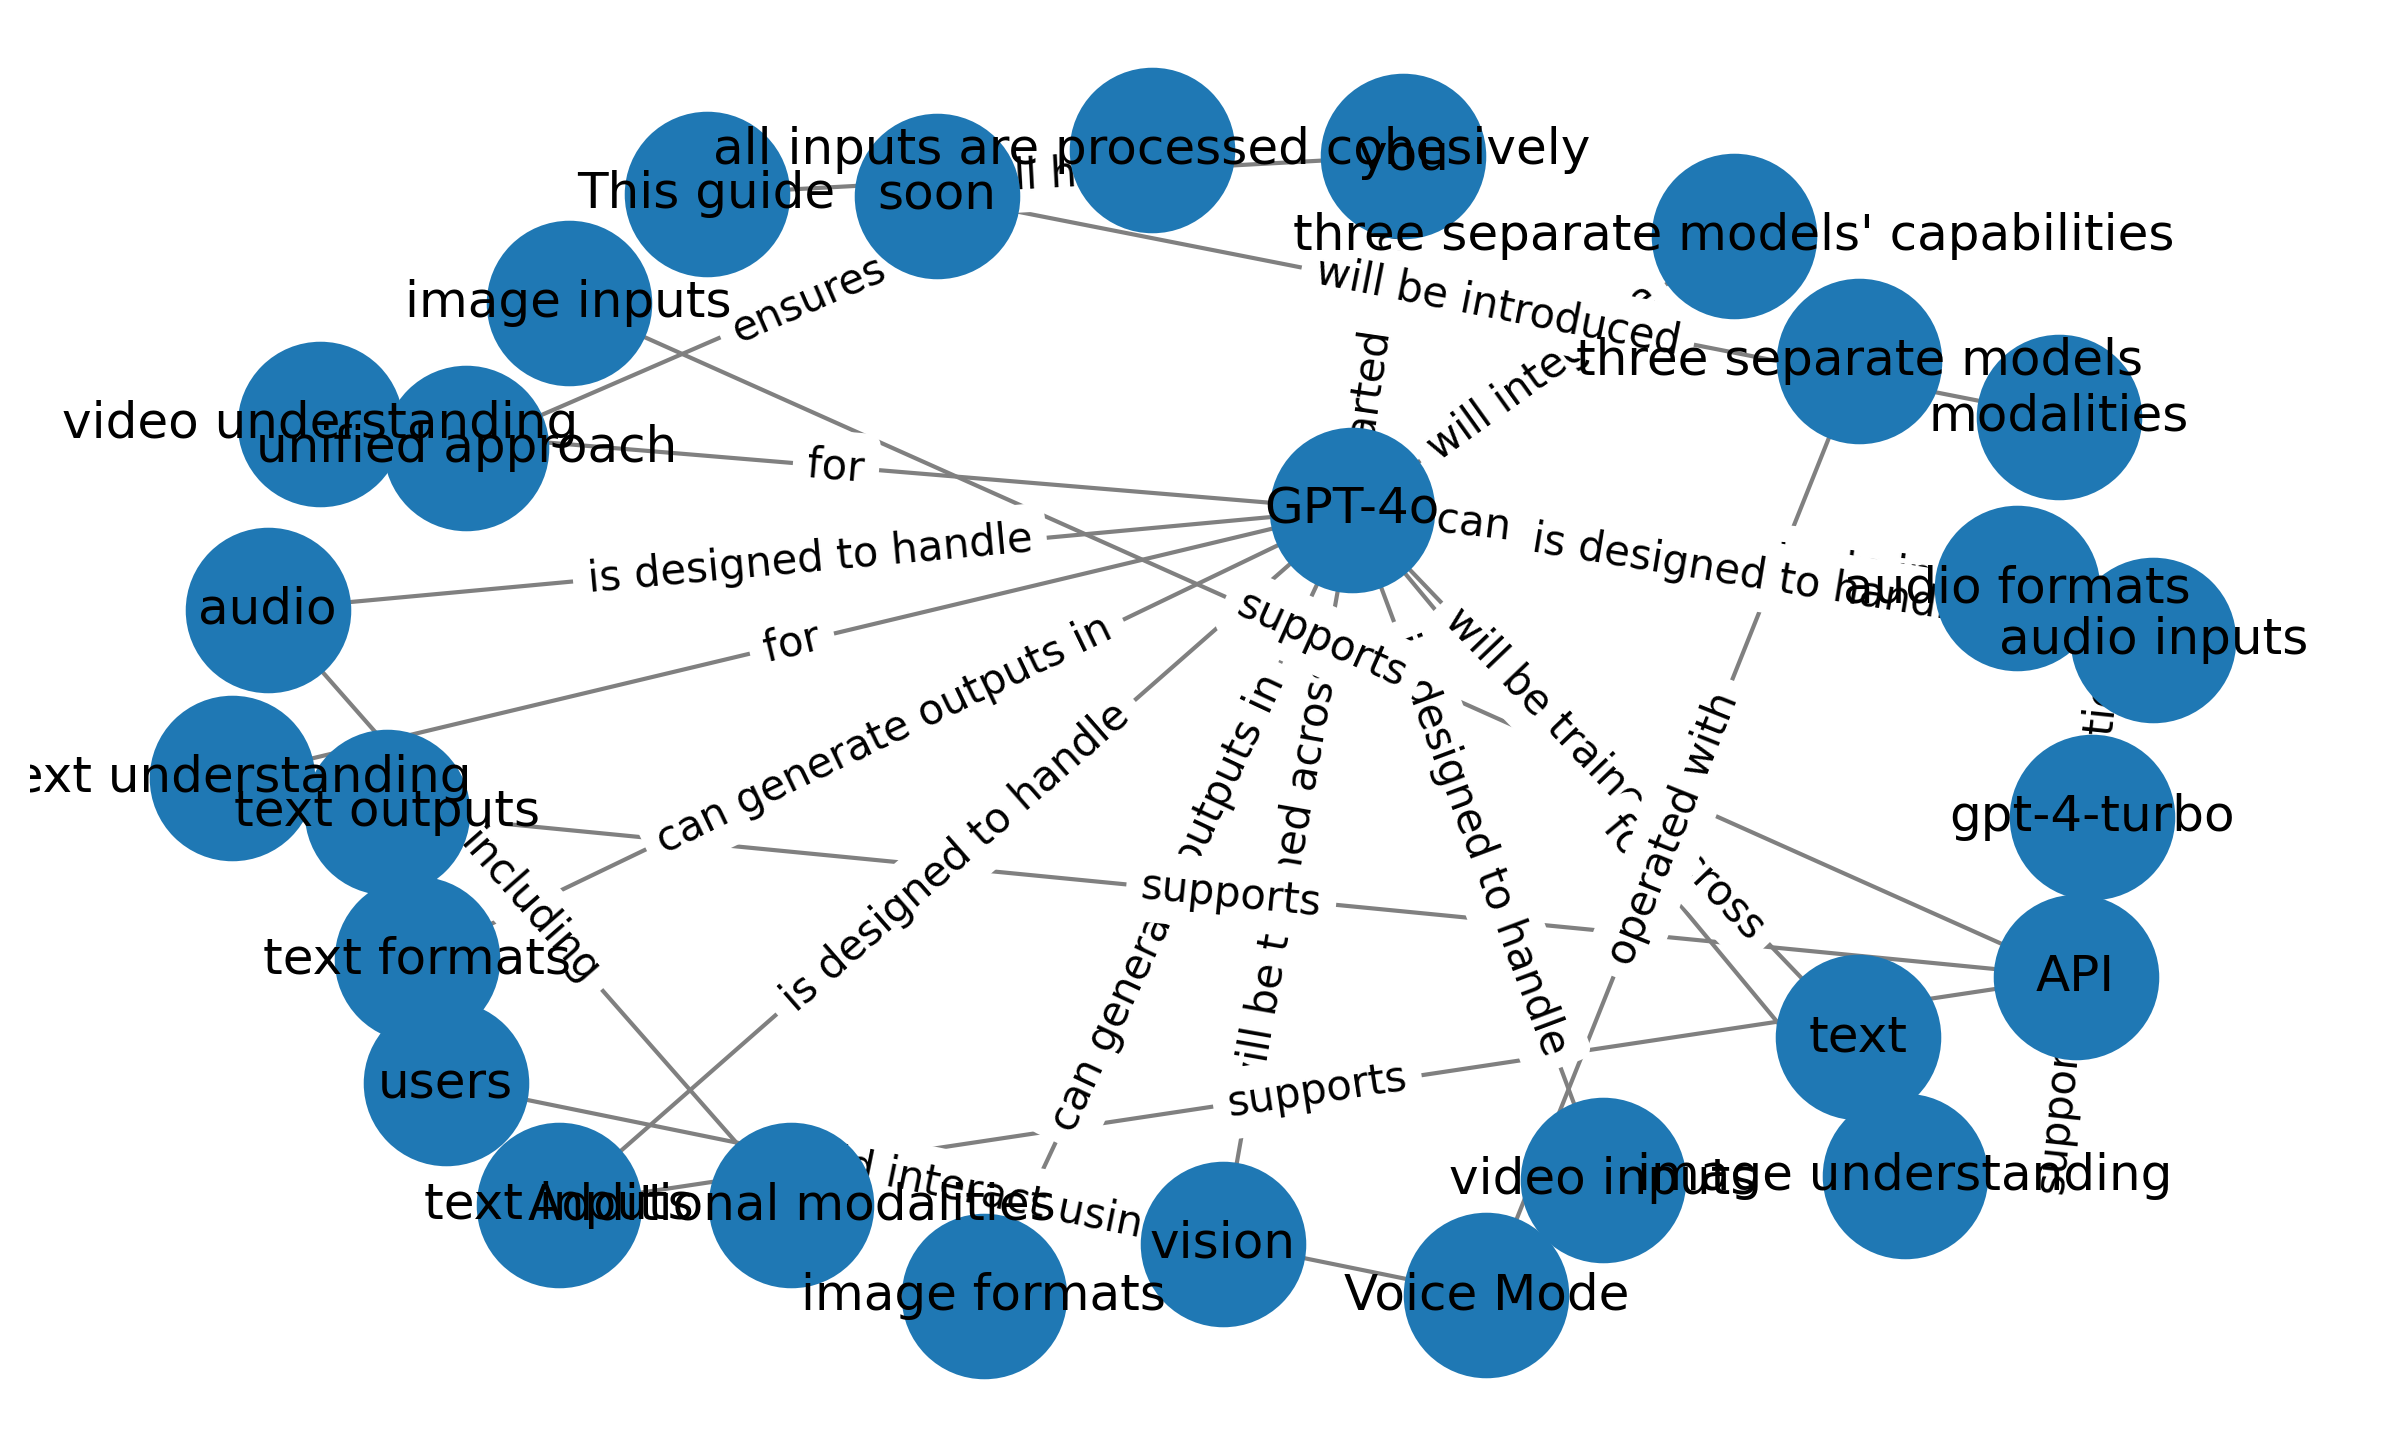

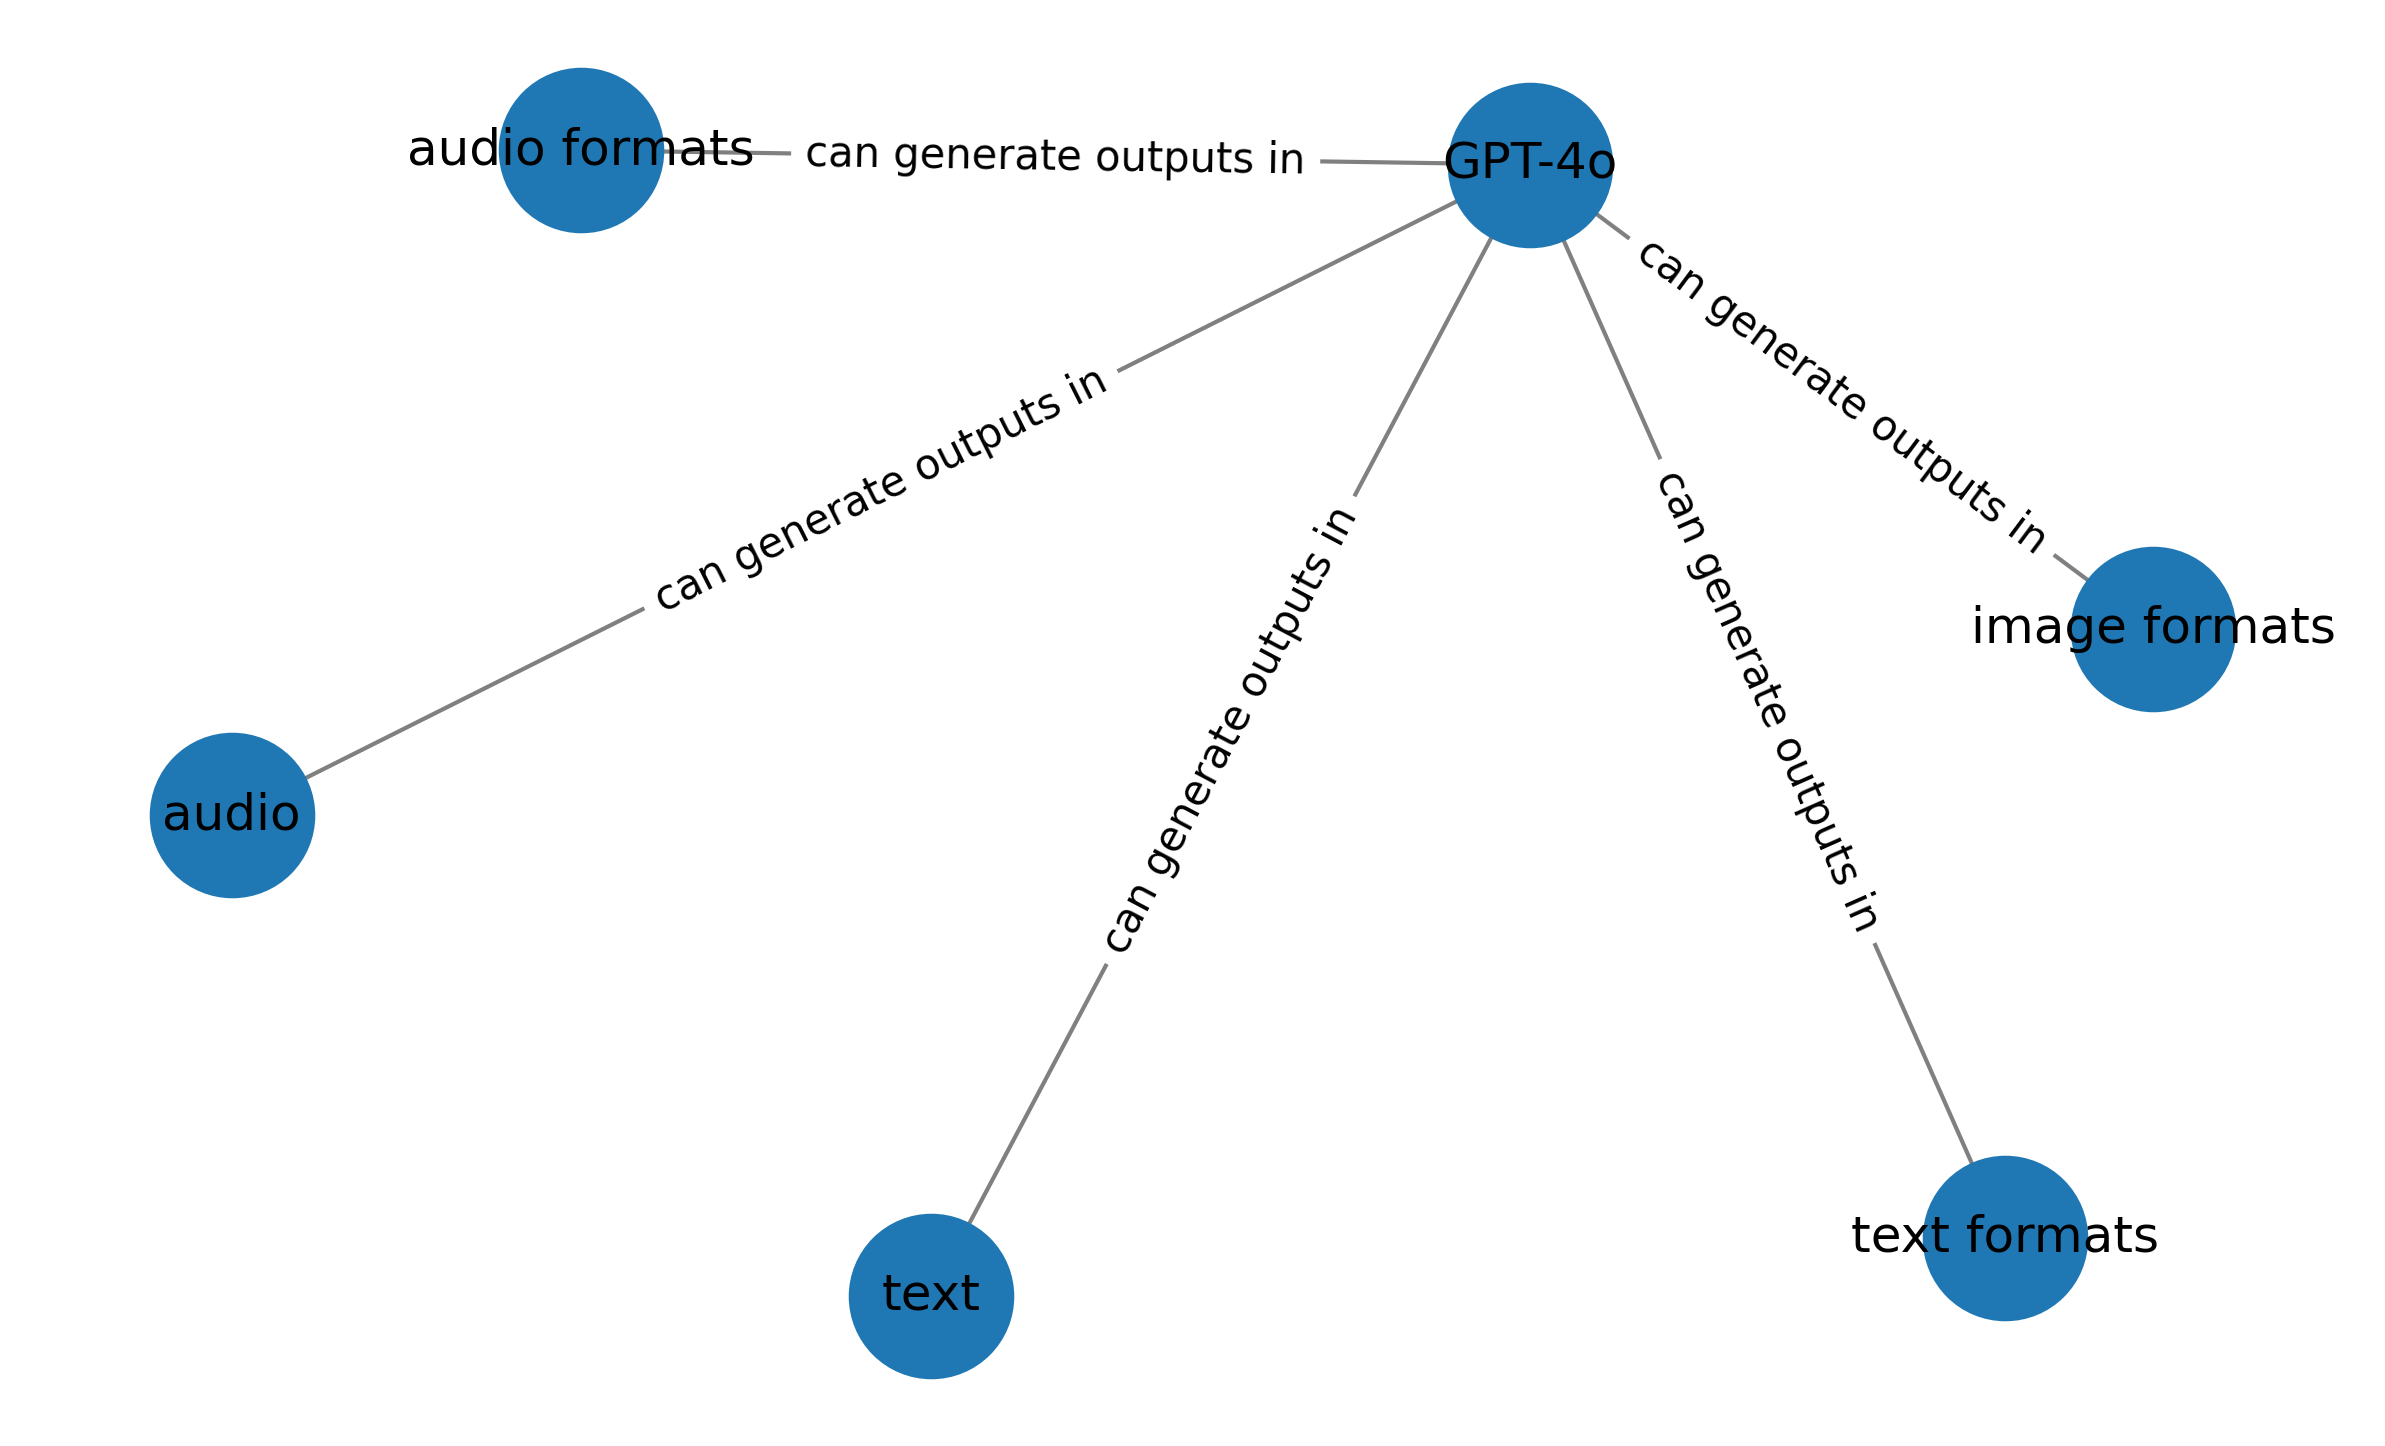

Response: GPT-4o can generate outputs in text, audio, audio formats, text formats, and image formats.


In [94]:
new_input = "GPT-4o ('o' for 'omni') is designed to handle a combination of text, audio, and video inputs, and can generate outputs in text, audio, and image formats."
new_kg = build_knowledge_graph(new_input)
merged_kg = merge_knowledge_graphs(merged_kg, new_kg)
plot_graph(merged_kg)

current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
title_with_datetime = f"updated_knowledge_graph_{formatted_datetime}.json"
with open(f'saved_kg/{title_with_datetime}', 'w') as f:
    json.dump(merged_kg, f)

question = "What formats can GPT-4o generate outputs in?"
parsed_kg = parse_knowledge_graph(merged_kg, question)
plot_graph(parsed_kg)

response = chat(
    f'''Use the following knowledge graph to answer the following question. 
    If you are unsure, output 'No Info'
    Knowledge Graph: {parsed_kg['List of triplets']}''',
    user_prompt=f'''Question: {question}'''
)
print('Response:', response)